In [32]:
!pip install transformers

In [33]:
import torch
from transformers import CLIPProcessor, CLIPModel

# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")

# 2. Load CLIP Model with SafeTensors
model_id = "openai/clip-vit-base-patch32"
print(f"⏳ Loading VLM: {model_id}...")

# --- THE FIX IS HERE (use_safetensors=True) ---
model = CLIPModel.from_pretrained(model_id, use_safetensors=True).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

print("✅ VLM Loaded Successfully!")

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 038c4693-39ea-4648-b1e1-7a26745c67fe)')' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-base-patch32/resolve/main/config.json
Retrying in 1s [Retry 1/5].


🚀 Device: cuda
⏳ Loading VLM: openai/clip-vit-base-patch32...
✅ VLM Loaded Successfully!


In [34]:
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import pandas as pd



# --- 2. Define the Feature Extraction Function ---
def extract_features(df, data_path="."):
    """
    Runs images and text through CLIP and returns the combined features.
    """
    all_features = []
    all_labels = []
    
    # Batch size needs to be small for 4GB VRAM
    BATCH_SIZE = 32 
    
    print(f"🚀 Extracting features for {len(df)} samples...")
    
    # Loop through dataframe in batches
    for i in tqdm(range(0, len(df), BATCH_SIZE)):
        batch = df.iloc[i : i + BATCH_SIZE]
        
        # Prepare Inputs
        images = []
        texts = []
        labels = []
        
        for _, row in batch.iterrows():
            # Image Path
            img_path = os.path.join(data_path, row['image'])
            try:
                # Open image
                image = Image.open(img_path).convert("RGB")
                images.append(image)
                
                # Text (Truncate to fit CLIP's limit)
                texts.append(row['tweet_text'][:77]) 
                
                # Label
                labels.append(row['label'])
            except:
                continue # Skip missing files

        if len(images) == 0: continue

        # Process with CLIP
        inputs = processor(
            text=texts, 
            images=images, 
            return_tensors="pt", 
            padding=True, 
            truncation=True
        ).to(device)

        # Get Features (No Gradient needed = Fast & Low Memory)
        with torch.no_grad():
            outputs = model(**inputs)
            
            # Get Image and Text Embeddings
            img_embeds = outputs.image_embeds
            text_embeds = outputs.text_embeds
            
            # Concatenate them
            combined_features = torch.cat((img_embeds, text_embeds), dim=1)
            
            # Move to CPU to save GPU memory
            all_features.append(combined_features.cpu().numpy())
            all_labels.extend(labels)

    # Combine all batches
    if len(all_features) > 0:
        X = np.concatenate(all_features, axis=0)
        y = np.array(all_labels)
        return X, y
    else:
        return np.array([]), np.array([])

# --- 3. Load Data & Run Extraction ---
# Define paths
train_path = os.path.join("data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv")
test_path = os.path.join("data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv")

# Load & Clean Training Data
train_df = pd.read_csv(train_path, sep='\t')
train_code = []
for i in range(train_df.shape[0]):
    if train_df.iloc[i]['label_image'] == 'informative':
        train_code.append(1)
    elif train_df.iloc[i]['label_image'] == 'not_informative':
        train_code.append(0)
    else:
        train_code.append(None)
train_df['label'] = train_code
train_df = train_df.dropna(subset=['label'])
train_df['label'] = train_df['label'].astype(int)

# Load & Clean Test Data
test_df = pd.read_csv(test_path, sep='\t')
test_code = []
for i in range(test_df.shape[0]):
    if test_df.iloc[i]['label_image'] == 'informative':
        test_code.append(1)
    elif test_df.iloc[i]['label_image'] == 'not_informative':
        test_code.append(0)
    else:
        test_code.append(None)
test_df['label'] = test_code
test_df = test_df.dropna(subset=['label'])
test_df['label'] = test_df['label'].astype(int)

print(f"✅ Data Reloaded! Train: {len(train_df)}, Test: {len(test_df)}")

# Run Extraction
print("\n--- Processing Training Data ---")
X_train, y_train = extract_features(train_df)

print("\n--- Processing Test Data ---")
X_test, y_test = extract_features(test_df)

print("\n✅ DONE! You can now train your classifier.")

✅ Data Reloaded! Train: 13608, Test: 2237

--- Processing Training Data ---
🚀 Extracting features for 13608 samples...


 52%|█████▏    | 221/426 [05:15<03:58,  1.17s/it]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 426/426 [09:08<00:00,  1.29s/it]



--- Processing Test Data ---
🚀 Extracting features for 2237 samples...


100%|██████████| 70/70 [01:18<00:00,  1.12s/it]


✅ DONE! You can now train your classifier.


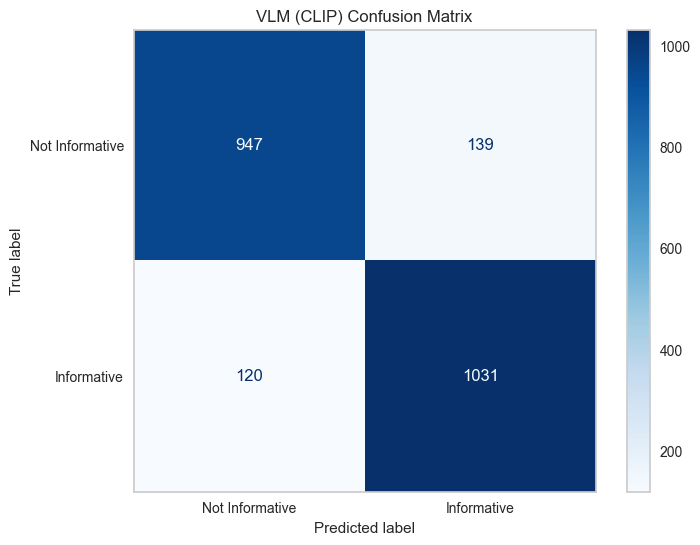

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# 2. Create the Plot
fig, ax = plt.subplots(figsize=(8, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Informative", "Informative"])
disp.plot(cmap='Blues', ax=ax)

plt.title("VLM (CLIP) Confusion Matrix")
plt.grid(False) # Turn off grid lines for cleaner look
plt.show()

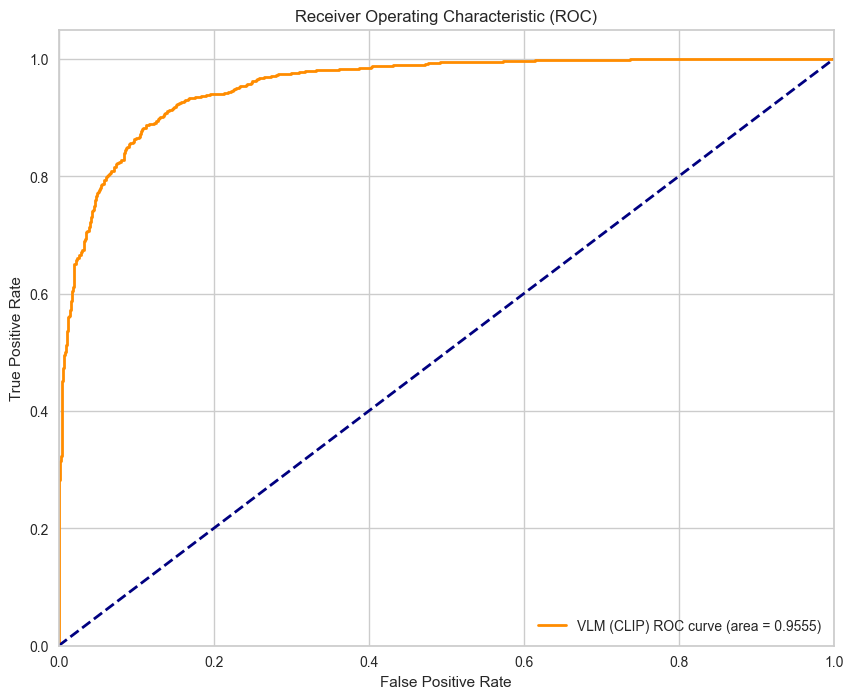

In [37]:
from sklearn.metrics import roc_curve, auc

# 1. Get Probabilities (Confidence scores) instead of just labels
y_prob = clf.predict_proba(X_test)[:, 1] # Get probability for Class 1 (Informative)

# 2. Calculate ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 3. Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'VLM (CLIP) ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal random guess line

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

🚀 Generating Learning Curve... (This tests the model on different data sizes)


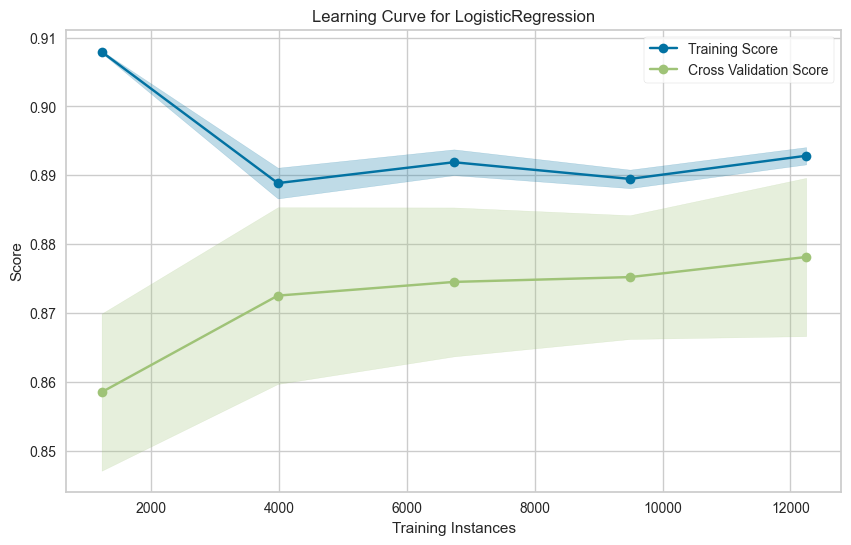

<Axes: title={'center': 'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [38]:
import matplotlib.pyplot as plt
from yellowbrick.model_selection import LearningCurve
from sklearn.linear_model import LogisticRegression

# 1. Setup the figure
fig, ax = plt.subplots(figsize=(10, 6))

# 2. Re-initialize the classifier (Yellowbrick needs a fresh instance)
#    We use the same settings as your trained VLM classifier
clf_for_plotting = LogisticRegression(max_iter=1000, C=1.0)

# 3. Initialize the Learning Curve Visualizer
visualizer = LearningCurve(
    clf_for_plotting, 
    cv=10,             # 10-fold cross-validation
    scoring='f1',      # Metric to track (F1 Score)
    n_jobs=-1,         # Use all CPU cores for speed
    ax=ax
)

# 4. Fit using your CLIP Training Features (X_train, y_train)
#    Note: We use the TRAINING set here. The curve will handle the splitting.
print("🚀 Generating Learning Curve... (This tests the model on different data sizes)")
visualizer.fit(X_train, y_train)        

# 5. Save and Show
visualizer.show(outpath="vlm_learning_curve.png")
visualizer.show()

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

# --- STEP 1: Train the Baseline Models (Text-Only & Image-Only) ---
print("⏳ Training Baseline Models for comparison...")

# Assuming CLIP uses ViT-Base-Patch32, the embedding size is 512
EMBED_DIM = 512 

# A. Train Text-Only Model
# We grab the *last* 512 columns (Text Features)
X_train_txt = X_train[:, EMBED_DIM:]
X_test_txt  = X_test[:, EMBED_DIM:]

clf_txt = LogisticRegression(max_iter=1000)
clf_txt.fit(X_train_txt, y_train)
print(f"✅ Text-Only Model Trained (Acc: {accuracy_score(y_test, clf_txt.predict(X_test_txt)):.4f})")

# B. Train Image-Only Model (Optional, but good for completeness)
# We grab the *first* 512 columns (Image Features)
X_train_img = X_train[:, :EMBED_DIM]
X_test_img  = X_test[:, :EMBED_DIM]

clf_img = LogisticRegression(max_iter=1000)
clf_img.fit(X_train_img, y_train)
print(f"✅ Image-Only Model Trained (Acc: {accuracy_score(y_test, clf_img.predict(X_test_img)):.4f})")


# --- STEP 2: Run McNemar's Test (Text vs. Multimodal) ---
print("\n📊 Running McNemar's Statistical Test...")

# 1. Get predictions
y_pred_text = clf_txt.predict(X_test_txt)
y_pred_multi = clf.predict(X_test) # Your main VLM model

# 2. Create Contingency Table
# [Both Correct, Text Correct/Multi Wrong]
# [Text Wrong/Multi Correct, Both Wrong]
both_correct = np.sum((y_pred_text == y_test) & (y_pred_multi == y_test))
text_correct = np.sum((y_pred_text == y_test) & (y_pred_multi != y_test))
multi_correct = np.sum((y_pred_text != y_test) & (y_pred_multi == y_test))
both_wrong    = np.sum((y_pred_text != y_test) & (y_pred_multi != y_test))

table = [[both_correct, text_correct],
         [multi_correct, both_wrong]]

# 3. Calculate P-Value
result = mcnemar(table, exact=True)

print(f"\n--- Results ---")
print(f"Statistic: {result.statistic}")
print(f"P-Value:   {result.pvalue}")

alpha = 0.05
if result.pvalue < alpha:
    print("✅ Result is Statistically Significant (We reject H0)")
    print("   This proves the VLM is genuinely better than  ViT + GPT-2")
else:
    print("❌ Result is NOT Statistically Significant")

⏳ Training Baseline Models for comparison...
✅ Text-Only Model Trained (Acc: 0.7242)
✅ Image-Only Model Trained (Acc: 0.8753)

📊 Running McNemar's Statistical Test...

--- Results ---
Statistic: 107.0
P-Value:   3.7705460487563104e-54
✅ Result is Statistically Significant (We reject H0)
   This proves the VLM is genuinely better than  ViT + GPT-2


Found 259 errors. Showing top 3 worst failures...


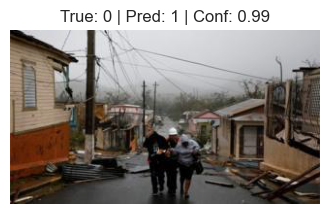

Tweet Text: (Hurricane Maria: Whole of Puerto Rico without power) - Xania News - https://t.co/GCxg69B7rp #XaniaNews https://t.co/HpxqtbeQGf
--------------------------------------------------


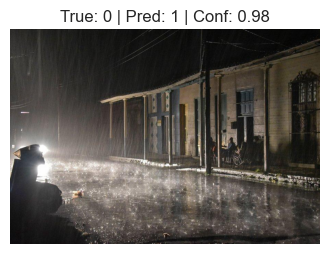

Tweet Text: RT @NinoskaPerezC: #Cuba #Irma if a picture is worth a thousand words this one needs only one: desolation https://t.co/e9uKSW5D0Q
--------------------------------------------------


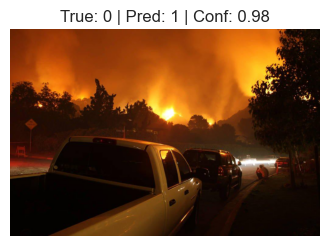

Tweet Text: ICYMI: Why California Wildfires Are Infernos In October https://t.co/sHsjtm3zxD https://t.co/N2yXSpw75i
--------------------------------------------------


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get probabilities
probs = clf.predict_proba(X_test)
confidence = np.max(probs, axis=1)

# 2. Find errors
errors_mask = y_pred != y_test
error_indices = np.where(errors_mask)[0]

# 3. Sort errors by confidence (Most confident errors are most interesting)
# We want to see cases where the model said "100% Informative" but it was actually "Not Informative"
sorted_errors = error_indices[np.argsort(confidence[error_indices])[::-1]]

print(f"Found {len(sorted_errors)} errors. Showing top 3 worst failures...")

# 4. Display Logic (Requires reloading test_df with images if you cleared memory)
for idx in sorted_errors[:3]:
    row = test_df.iloc[idx]
    conf = confidence[idx]
    pred_label = y_pred[idx]
    true_label = y_test[idx]
    
    img_path = os.path.join(".", row['image'])
    
    try:
        img = Image.open(img_path)
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.title(f"True: {true_label} | Pred: {pred_label} | Conf: {conf:.2f}")
        plt.axis('off')
        plt.show()
        print(f"Tweet Text: {row['tweet_text']}")
        print("-" * 50)
    except:
        pass

🚀 Generating Predictions...
✅ Results saved to 'vlm_final_results.csv'

--- Showing 3 Random PREDICTIONS ---


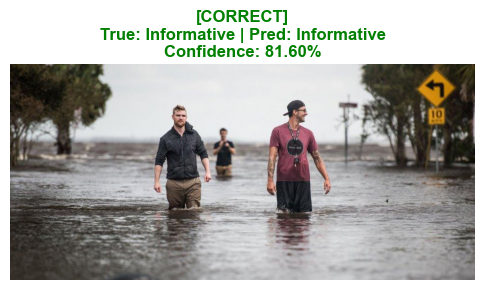

📝 Tweet Text: "Why There Is No Magic Formula to Recovery After a Disaster https://t.co/M5LDJBw8IM https://t.co/6rpk8QDwcc"
------------------------------------------------------------


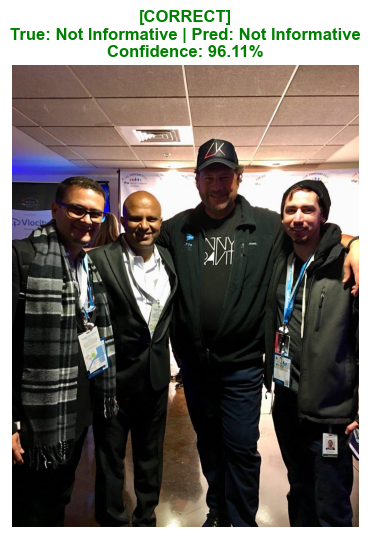

📝 Tweet Text: "Helping Puerto Rico! Thanks #salesforce! https://t.co/IVGrbSutlm"
------------------------------------------------------------


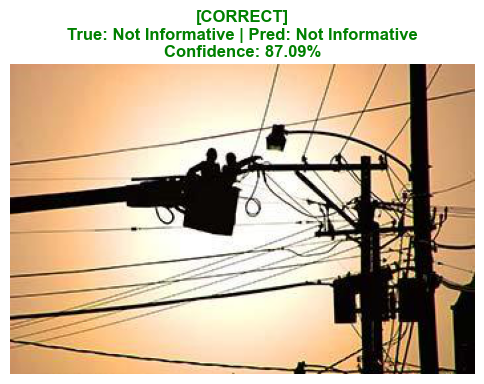

📝 Tweet Text: "Power Grid: Florida's Irma outages continue despite power grid upgrades https://t.co/S8LLMZqaB6 #renewable #solar… https://t.co/TebgPlL1H5"
------------------------------------------------------------

--- Showing 3 Random ERRORS (Total Errors: 259) ---


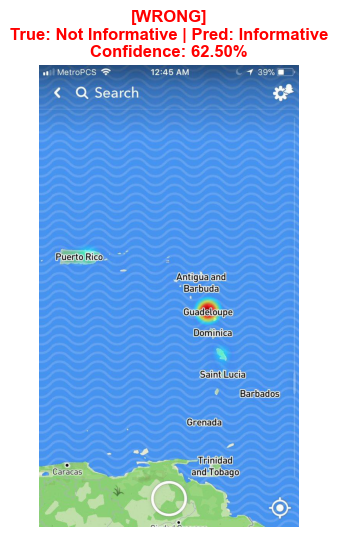

📝 Tweet Text: "RT @Abelon94: Yâ€™all can check live #HurricaneMaria on #snapchat we can keep track of what is really happening https://t.co/HpzQ33e8wh"
------------------------------------------------------------


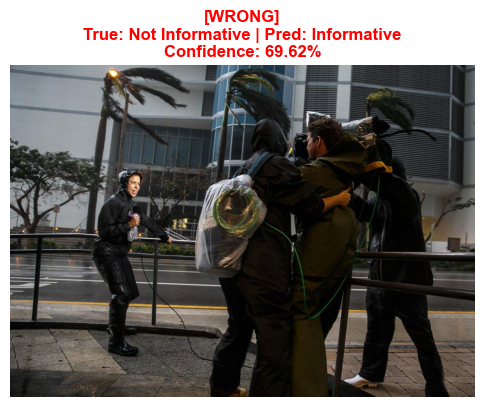

📝 Tweet Text: "Reporters compare Harvey and Irmaâ€™s impacts. - https://t.co/HQ2djQYgRy https://t.co/AQ6IQomxk2"
------------------------------------------------------------


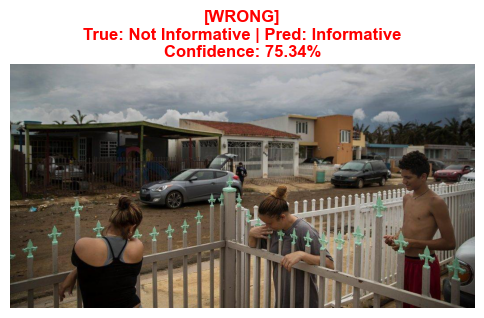

📝 Tweet Text: "Puerto Rico Is Getting a Surge of Aid, Governor Says https://t.co/pT6z1wkQkb https://t.co/yyGOzsWWUp"
------------------------------------------------------------


In [41]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import pandas as pd

# 1. Get Predictions and Probabilities from your Classifier
print("🚀 Generating Predictions...")
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)  # Probabilities for [Class 0, Class 1]

# 2. Create a Results DataFrame
# We combine the original test data with our new predictions
results_df = test_df.copy()
results_df['predicted_label'] = y_pred
results_df['confidence'] = np.max(y_prob, axis=1) # Take the higher probability
results_df['is_correct'] = results_df['predicted_label'] == results_df['label']

# 3. Save detailed results to CSV (Useful for your paper!)
results_df.to_csv("vlm_final_results.csv", index=False, sep='\t')
print("✅ Results saved to 'vlm_final_results.csv'")

# 4. Visualization Function
def show_vlm_predictions(num_samples=5, show_only_errors=False):
    """
    Displays images with their predicted vs true labels.
    """
    # Filter indices based on what you want to see
    if show_only_errors:
        indices = results_df[results_df['is_correct'] == False].index
        print(f"\n--- Showing {num_samples} Random ERRORS (Total Errors: {len(indices)}) ---")
    else:
        indices = results_df.index
        print(f"\n--- Showing {num_samples} Random PREDICTIONS ---")

    # Pick random samples
    if len(indices) < num_samples:
        sample_indices = indices
    else:
        sample_indices = np.random.choice(indices, num_samples, replace=False)

    label_map = {0: "Not Informative", 1: "Informative"}

    for idx in sample_indices:
        row = results_df.loc[idx]
        
        # Get file path
        # Note: Adjust path="." if your images are in a subfolder
        img_path = os.path.join(".", row['image']) 
        
        try:
            # Load Image
            img = Image.open(img_path)
            
            # Setup Plot
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            
            # Title Color: Green = Correct, Red = Wrong
            color = 'green' if row['is_correct'] else 'red'
            status = "CORRECT" if row['is_correct'] else "WRONG"
            
            title_text = (f"[{status}]\n"
                          f"True: {label_map[row['label']]} | Pred: {label_map[row['predicted_label']]}\n"
                          f"Confidence: {row['confidence']:.2%}")
            
            plt.title(title_text, color=color, fontweight='bold', fontsize=12)
            plt.axis('off')
            plt.show()
            
            # Print the text for context
            print(f"📝 Tweet Text: \"{row['tweet_text']}\"")
            print("-" * 60)
            
        except Exception as e:
            print(f"⚠️ Could not load image: {img_path}")

# --- 5. RUN IT ---

# Show 3 random correct/incorrect predictions
show_vlm_predictions(num_samples=3, show_only_errors=False)

# Optional: Uncomment below to see 3 places where the model failed
show_vlm_predictions(num_samples=3, show_only_errors=True)

⏳ Computing t-SNE (This creates a 2D map of your data)...


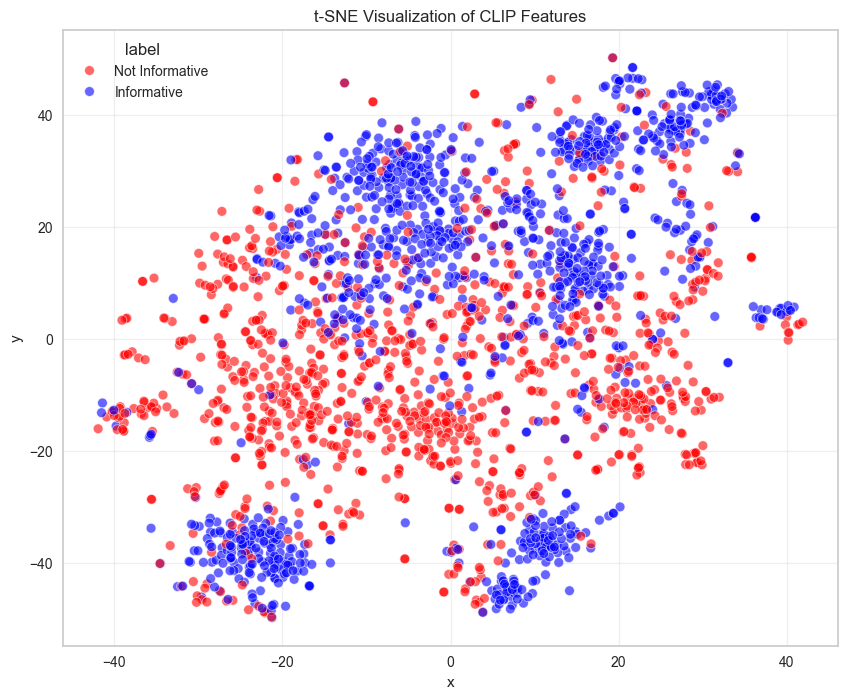

In [43]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_tsne(X, y, title="t-SNE Visualization of CLIP Features"):
    print("⏳ Computing t-SNE (This creates a 2D map of your data)...")
    
    # FIX: Removed 'n_iter' as it defaults to 1000 and was causing the error
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    
    # We fit and transform in one step
    X_embedded = tsne.fit_transform(X)
    
    # Create a DataFrame for plotting
    tsne_df = pd.DataFrame(X_embedded, columns=['x', 'y'])
    tsne_df['label'] = y
    tsne_df['label'] = tsne_df['label'].map({0: 'Not Informative', 1: 'Informative'})
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=tsne_df, 
        x='x', 
        y='y', 
        hue='label', 
        palette={'Not Informative': 'red', 'Informative': 'blue'},
        alpha=0.6
    )
    
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

# Run it
plot_tsne(X_test, y_test)

In [44]:
from sklearn.model_selection import GridSearchCV

# 1. Define the parameter grid
# 'C' controls regularization strength (smaller = stronger regularization)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

# 2. Setup Grid Search with Cross-Validation
print("🚀 Tuning Hyperparameters...")
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000), 
    param_grid, 
    cv=5,            # 5-Fold Cross Validation
    scoring='accuracy', 
    n_jobs=-1,       # Use all CPU cores
    verbose=1
)

# 3. Fit to Training Data
grid_search.fit(X_train, y_train)

# 4. Get the Best Model
best_clf = grid_search.best_estimator_

print(f"\n✅ Best Parameters Found: {grid_search.best_params_}")
print(f"✅ Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# 5. Use this 'best_clf' for your final predictions
clf = best_clf

🚀 Tuning Hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

✅ Best Parameters Found: {'C': 1, 'solver': 'lbfgs'}
✅ Best Cross-Validation Accuracy: 0.8739


In [45]:
import random
import os
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("✅ Reproducibility Seeds Set")

✅ Reproducibility Seeds Set


In [46]:
import time

def benchmark_inference(model, processor, clf, df, num_samples=100):
    print(f"⏱️ Benchmarking Inference Speed on {num_samples} samples...")
    
    # Select a small subset
    subset = df.iloc[:num_samples]
    
    start_time = time.time()
    
    # 1. Simulate the Full Pipeline
    for _, row in subset.iterrows():
        # A. Load Image
        img_path = os.path.join(".", row['image'])
        try:
            image = Image.open(img_path).convert("RGB")
            text = row['tweet_text'][:77]
            
            # B. Extract Features (CLIP)
            inputs = processor(text=[text], images=[image], return_tensors="pt", padding=True).to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                features = torch.cat((outputs.image_embeds, outputs.text_embeds), dim=1).cpu().numpy()
            
            # C. Predict (Classifier)
            _ = clf.predict(features)
            
        except:
            continue
            
    end_time = time.time()
    total_time = end_time - start_time
    
    fps = num_samples / total_time
    latency_ms = (total_time / num_samples) * 1000
    
    print(f"⚡ Throughput: {fps:.2f} samples/sec")
    print(f"⚡ Latency:    {latency_ms:.2f} ms/sample")
    return fps, latency_ms

# Run Benchmark
benchmark_inference(model, processor, clf, test_df, num_samples=200)

⏱️ Benchmarking Inference Speed on 200 samples...


d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


⚡ Throughput: 13.71 samples/sec
⚡ Latency:    72.93 ms/sample


(13.711987789434701, 72.92888641357422)

In [47]:
# Extract results from the Grid Search
cv_results = pd.DataFrame(grid_search.cv_results_)

# Get the best row
best_row = cv_results.iloc[grid_search.best_index_]

mean_score = best_row['mean_test_score']
std_score = best_row['std_test_score']

print(f"📊 Model Stability Report:")
print(f"   Mean Accuracy: {mean_score:.4f}")
print(f"   Standard Deviation: ±{std_score:.4f}")
print(f"   95% Confidence Interval: [{mean_score - 2*std_score:.4f}, {mean_score + 2*std_score:.4f}]")

📊 Model Stability Report:
   Mean Accuracy: 0.8739
   Standard Deviation: ±0.0052
   95% Confidence Interval: [0.8635, 0.8843]


In [48]:
from sklearn.metrics import accuracy_score

def run_zero_shot(df):
    print("🔮 Running Zero-Shot Baseline (No Training)...")
    
    preds = []
    truth = []
    
    # Define prompts - CLIP compares the image to these descriptions
    # We ask: "Does this image match 'disaster' or 'safe'?"
    prompts = ["a photo of a disaster, damage, or emergency", "a photo of a normal scene, safe, no danger"]
    
    text_inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            image = Image.open(os.path.join(".", row['image'])).convert("RGB")
            
            # Process Image
            image_inputs = processor(images=image, return_tensors="pt").to(device)
            
            with torch.no_grad():
                # CLIP calculates similarity between Image and the 2 Prompts
                outputs = model(**image_inputs, **text_inputs)
                logits_per_image = outputs.logits_per_image # [1, 2]
                probs = logits_per_image.softmax(dim=1)
                
                # Index 0 = Disaster (Informative), Index 1 = Normal (Not Informative)
                # Note: This mapping depends on your prompt order!
                pred = 1 if probs[0][0] > probs[0][1] else 0
                
                preds.append(pred)
                truth.append(row['label'])
        except:
            continue
            
    acc = accuracy_score(truth, preds)
    print(f"🔮 Zero-Shot Accuracy: {acc:.4f}")
    return acc

# Run it
zero_shot_acc = run_zero_shot(test_df.iloc[:500]) # Run on subset to save time

🔮 Running Zero-Shot Baseline (No Training)...


  4%|▍         | 21/500 [00:01<00:24, 19.55it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 500/500 [00:28<00:00, 17.26it/s]

🔮 Zero-Shot Accuracy: 0.6060


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Initialize Classifier
# We use Logistic Regression because CLIP features are linearly separable
clf = LogisticRegression(max_iter=1000, C=1.0)

# 2. Train (This takes seconds)
print("🚀 Training Classifier...")
clf.fit(X_train, y_train)

# 3. Predict
print("🚀 Running Predictions...")
y_pred = clf.predict(X_test)

# 4. Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"\n🏆 VLM Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

🚀 Training Classifier...
🚀 Running Predictions...

🏆 VLM Accuracy: 0.8842

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1086
           1       0.88      0.90      0.89      1151

    accuracy                           0.88      2237
   macro avg       0.88      0.88      0.88      2237
weighted avg       0.88      0.88      0.88      2237

